In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [ ]:
import argparse
from data_loader import load_and_preprocess_data
from model import create_cnn_model, train_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

### Data Preprocessing

 Define attack categories

In [ ]:
ATTACK_CATEGORIES_19 = { 
    'ARP_Spoofing': 'Spoofing',
    'MQTT-DDoS-Connect_Flood': 'MQTT-DDoS-Connect_Flood',
    'MQTT-DDoS-Publish_Flood': 'MQTT-DDoS-Publish_Flood',
    'MQTT-DoS-Connect_Flood': 'MQTT-DoS-Connect_Flood',
    'MQTT-DoS-Publish_Flood': 'MQTT-DoS-Publish_Flood',
    'MQTT-Malformed_Data': 'MQTT-Malformed_Data',
    'Recon-OS_Scan': 'Recon-OS_Scan',
    'Recon-Ping_Sweep': 'Recon-Ping_Sweep',
    'Recon-Port_Scan': 'Recon-Port_Scan',
    'Recon-VulScan': 'Recon-VulScan',
    'TCP_IP-DDoS-ICMP': 'DDoS-ICMP',
    'TCP_IP-DDoS-SYN': 'DDoS-SYN',
    'TCP_IP-DDoS-TCP': 'DDoS-TCP',
    'TCP_IP-DDoS-UDP': 'DDoS-UDP',
    'TCP_IP-DoS-ICMP': 'DoS-ICMP',
    'TCP_IP-DoS-SYN': 'DoS-SYN',
    'TCP_IP-DoS-TCP': 'DoS-TCP',
    'TCP_IP-DoS-UDP': 'DoS-UDP',
    'Benign': 'Benign'
}

ATTACK_CATEGORIES_6 = {  
    'Spoofing': 'Spoofing',
    'MQTT-DDoS-Connect_Flood': 'MQTT',
    'MQTT-DDoS-Publish_Flood': 'MQTT',
    'MQTT-DoS-Connect_Flood': 'MQTT',
    'MQTT-DoS-Publish_Flood': 'MQTT',
    'MQTT-Malformed_Data': 'MQTT',
    'Recon-OS_Scan': 'Recon',
    'Recon-Ping_Sweep': 'Recon',
    'Recon-Port_Scan': 'Recon',
    'Recon-VulScan': 'Recon',
    'DDoS-ICMP': 'DDoS',
    'DDoS-SYN': 'DDoS',
    'DDoS-TCP': 'DDoS',
    'DDoS-UDP': 'DDoS',
    'DoS-ICMP': 'DoS',
    'DoS-SYN': 'DoS',
    'DoS-TCP': 'DoS',
    'DoS-UDP': 'DoS',
    'Benign': 'Benign'
}

ATTACK_CATEGORIES_2 = {  
    'ARP_Spoofing': 'attack',
    'MQTT-DDoS-Connect_Flood': 'attack',
    'MQTT-DDoS-Publish_Flood': 'attack',
    'MQTT-DoS-Connect_Flood': 'attack',
    'MQTT-DoS-Publish_Flood': 'attack',
    'MQTT-Malformed_Data': 'attack',
    'Recon-OS_Scan': 'attack',
    'Recon-Ping_Sweep': 'attack',
    'Recon-Port_Scan': 'attack',
    'Recon-VulScan': 'attack',
    'TCP_IP-DDoS-ICMP': 'attack',
    'TCP_IP-DDoS-SYN': 'attack',
    'TCP_IP-DDoS-TCP': 'attack',
    'TCP_IP-DDoS-UDP': 'attack',
    'TCP_IP-DoS-ICMP': 'attack',
    'TCP_IP-DoS-SYN': 'attack',
    'TCP_IP-DoS-TCP': 'attack',
    'TCP_IP-DoS-UDP': 'attack',
    'Benign': 'Benign'
}

def get_attack_category(file_name, class_config): 
    """Get attack category from file name."""

    if class_config == 2:
        categories = ATTACK_CATEGORIES_2
    elif class_config == 6:
        categories = ATTACK_CATEGORIES_6
    else:  # Default to 19 classes 
        categories = ATTACK_CATEGORIES_19  

    for key in categories:
        if key in file_name:
            return categories[key]

Load and Preprocess

In [ ]:
def load_and_preprocess_data(data_dir, class_config):
    """Load, preprocess, and prepare data for training."""
    train_files = [f"{data_dir}/train/{f}" for f in os.listdir(f"{data_dir}/train") if f.endswith('.csv')]
    test_files = [f"{data_dir}/test/{f}" for f in os.listdir(f"{data_dir}/test") if f.endswith('.csv')]

    train_df = pd.concat([pd.read_csv(f).assign(file=f) for f in train_files], ignore_index=True)
    test_df = pd.concat([pd.read_csv(f).assign(file=f) for f in test_files], ignore_index=True)

    train_df['Attack_Type'] = train_df['file'].apply(lambda x: get_attack_category(x, class_config))
    test_df['Attack_Type'] = test_df['file'].apply(lambda x: get_attack_category(x, class_config))

    X_train = train_df.drop(['Attack_Type', 'file'], axis=1)
    y_train = train_df['Attack_Type']
    X_test = test_df.drop(['Attack_Type', 'file'], axis=1)
    y_test = test_df['Attack_Type']

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)

    X_train, X_val, y_train_categorical, y_val_categorical = train_test_split(
        X_train, y_train_categorical, test_size=0.2, random_state=42
    )

    # Replace inf/-inf with NaN
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, X_val, X_test, y_train_categorical, y_val_categorical, y_test_categorical, label_encoder


Defining the model

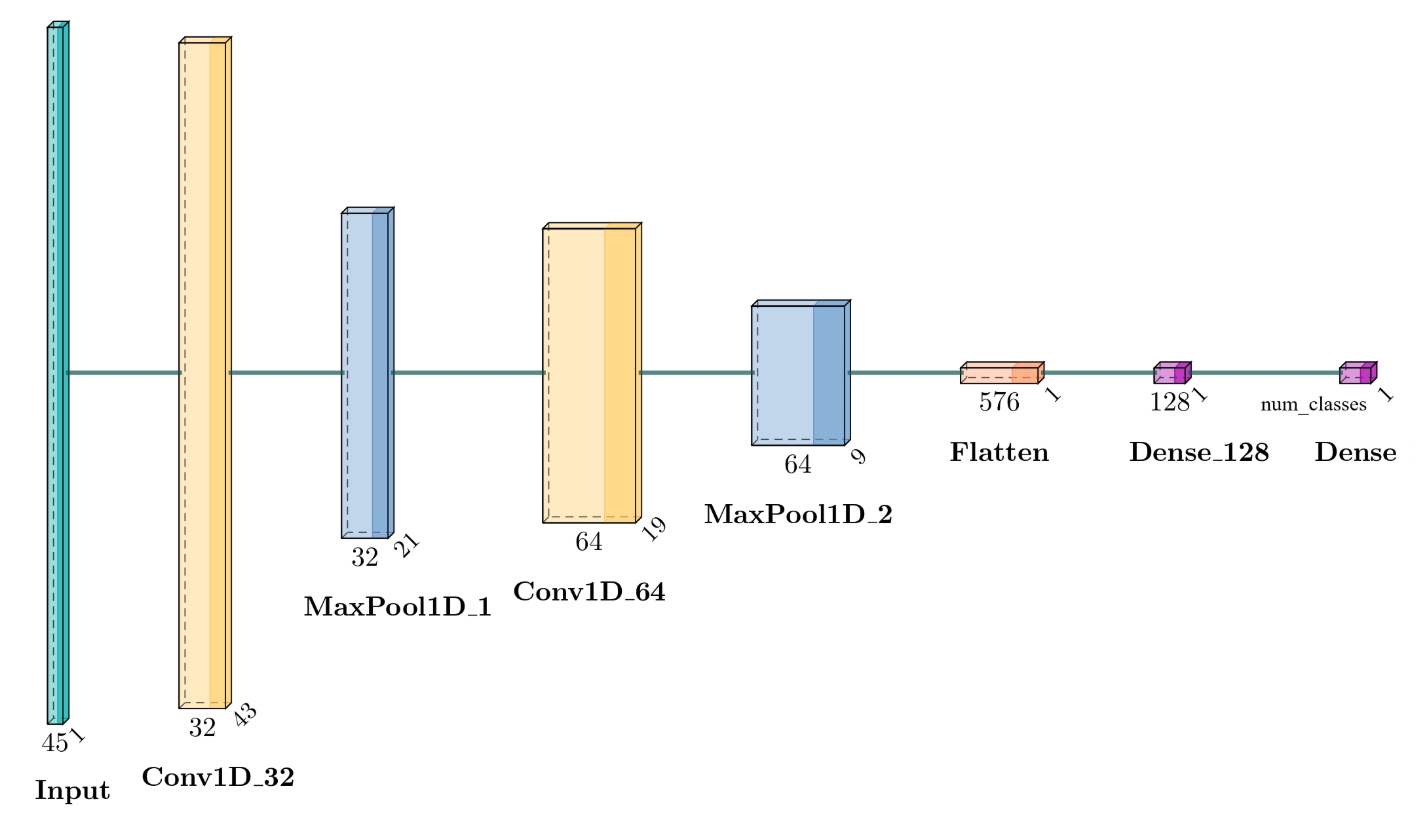

In [ ]:
def create_cnn_model(input_shape, num_classes):
    """Create and compile the CNN model."""
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax')) 

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Train the model

In [ ]:
def train_model(model, X_train, y_train_categorical, X_val, y_val_categorical, epochs=10, batch_size=32):
    """Train the CNN model."""
    model.fit(X_train, y_train_categorical, epochs=epochs, batch_size=batch_size, 
              validation_data=(X_val, y_val_categorical))
    return model

Calling the model

In [ ]:
# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description="Train and evaluate a CNN for network intrusion detection.")
#     parser.add_argument("--class_config", type=int, choices=[2, 6, 19], default=2,
#                         help="Number of classes for classification (2, 6, or 19)")
#     args = parser.parse_args()

#     # Get the absolute path of the directory where this script is located 
#     script_dir = os.path.dirname(os.path.abspath(__file__)) 
#     # Construct the full path to your data directory
#     data_dir = os.path.join(script_dir, '..', 'data') 

#     # Pass data_dir to the function:
#     X_train, X_val, X_test, y_train_categorical, y_val_categorical, y_test_categorical, label_encoder = load_and_preprocess_data(
#         data_dir, args.class_config)  # Pass data_dir here 

#     input_shape = (X_train.shape[1], 1) 
#     model = create_cnn_model(input_shape, y_train_categorical.shape[1])

#     import tensorflow as tf 
#     if tf.test.gpu_device_name():
#         print('GPU is available!')
#     else:
#         print('GPU is not available. Using CPU.')

#     model = train_model(model, X_train, y_train_categorical, X_val, y_val_categorical)

#     loss, accuracy = model.evaluate(X_test, y_test_categorical)
#     print(f"Test Loss: {loss:.4f}")
#     print(f"Test Accuracy: {accuracy:.4f}")

#     y_pred_categorical = model.predict(X_test)
#     y_pred_encoded = y_pred_categorical.argmax(axis=1)
#     y_pred = label_encoder.inverse_transform(y_pred_encoded)

#     y_test_decoded = label_encoder.inverse_transform(y_test_categorical.argmax(axis=1))

#     accuracy = accuracy_score(y_test_decoded, y_pred)
#     precision = precision_score(y_test_decoded, y_pred, average='weighted')
#     recall = recall_score(y_test_decoded, y_pred, average='weighted')
#     f1 = f1_score(y_test_decoded, y_pred, average='weighted')

#     print("Accuracy:", accuracy)
#     print("Precision:", precision)
#     print("Recall:", recall)
#     print("F1-Score:", f1)
#     print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred))
#     print("\nConfusion Matrix:\n", confusion_matrix(y_test_decoded, y_pred))

In [ ]:
# Instead of argparse
class_config = 2  # change this to 6 or 19 as needed

# __file__ doesn’t exist in notebooks, so use direct path
data_dir = "../data"  # adjust path if notebook is in diff folder

# Load data
X_train, X_val, X_test, y_train_categorical, y_val_categorical, y_test_categorical, label_encoder = load_and_preprocess_data(
    data_dir, class_config
)

# Build model
input_shape = (X_train.shape[1], 1) 
model = create_cnn_model(input_shape, y_train_categorical.shape[1])

# Check GPU
if tf.test.gpu_device_name():
    print('GPU is available!')
else:
    print('GPU is not available. Using CPU.')

# Train model
model = train_model(model, X_train, y_train_categorical, X_val, y_val_categorical)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions + metrics
y_pred_categorical = model.predict(X_test)
y_pred_encoded = y_pred_categorical.argmax(axis=1)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

y_test_decoded = label_encoder.inverse_transform(y_test_categorical.argmax(axis=1))

accuracy = accuracy_score(y_test_decoded, y_pred)
precision = precision_score(y_test_decoded, y_pred, average='weighted')
recall = recall_score(y_test_decoded, y_pred, average='weighted')
f1 = f1_score(y_test_decoded, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_decoded, y_pred))


GPU is available!
Epoch 1/10
174685/174685 [==============================] - 715s 4ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 2/10
174685/174685 [==============================] - 666s 4ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 3/10
174685/174685 [==============================] - 1021s 6ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 4/10
174685/174685 [==============================] - 1541s 9ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 5/10
174685/174685 [==============================] - 1660s 10ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 6/10
174685/174685 [==============================] - 1678s 10ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 7/10
174685/174685 [==============================] - 35393s 203ms/ste

In [ ]:
model.save("cnn_model.keras")

In [ ]:
model.save_weights("cnn_weights.h5")